In [41]:
import os, sys, glob, shutil, json
import cv2

from PIL import Image
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from tensorboardX import SummaryWriter   # tensorboard
import torchvision.transforms as transforms


print(torch.__version__)
print(torch.cuda.is_available())

1.7.0+cu101
True


In [42]:
class SVHNDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label 
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None

    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
        
        # 原始SVHN中类别10为填充的数字X, 最多字符为6
        lbl = np.array(self.img_label[index], dtype=np.int)
        lbl = list(lbl)  + (4 - len(lbl)) * [10]
        
        return img, torch.from_numpy(np.array(lbl[:4]))

    def __len__(self):
        return len(self.img_path)


train_path = glob.glob('../input/mchar_train/*.png')
train_path.sort()
train_json = json.load(open('../input/mchar_train.json'))
train_label = [train_json[x]['label'] for x in train_json]

val_path = glob.glob('../input/mchar_val/*.png')
val_path.sort()
val_json = json.load(open('../input/mchar_val.json'))
val_label = [val_json[x]['label'] for x in val_json]

# BATCH_SIZE = 10
BATCH_SIZE = 1000

train_loader = torch.utils.data.DataLoader(
        SVHNDataset(train_path, train_label,
                   transforms.Compose([
                       transforms.Resize((64, 128)),
                       transforms.RandomCrop((60, 120)),
                       transforms.ColorJitter(0.3, 0.3, 0.2),
                       transforms.RandomRotation(5),
                       transforms.ToTensor(),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])), 
    batch_size=BATCH_SIZE, # 每批样本个数
    shuffle=True, # 是否打乱顺序
    num_workers=10, # 读取的线程个数
)

    
val_loader = torch.utils.data.DataLoader(
    SVHNDataset(val_path, val_label,
                    transforms.Compose([
#                        transforms.Resize((64, 128)),
                        transforms.Resize((60, 120)),
                    #    transforms.ColorJitter(0.3, 0.3, 0.2),
                    #    transforms.RandomRotation(5),
                       transforms.ToTensor(),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])), 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=10, 
)

In [43]:
# 定义模型
class SVHN_Model1(nn.Module):
    def __init__(self):
        super(SVHN_Model1, self).__init__()
        # CNN提取特征模块
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2)),
            nn.ReLU(),  
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2)),
            nn.ReLU(), 
            nn.MaxPool2d(2),
        )
        # 
        self.fc1 = nn.Linear(32*3*7, 11)
        self.fc2 = nn.Linear(32*3*7, 11)
        self.fc3 = nn.Linear(32*3*7, 11)
        self.fc4 = nn.Linear(32*3*7, 11)
    
    def forward(self, img):        
        feat = self.cnn(img)
        feat = feat.view(feat.shape[0], -1)
        c1 = self.fc1(feat)
        c2 = self.fc2(feat)
        c3 = self.fc3(feat)
        c4 = self.fc4(feat)
        return c1, c2, c3, c4

# model = SVHN_Model1()
model = SVHN_Model1().cuda()
# 损失函数
criterion = nn.CrossEntropyLoss(size_average=False)
# 优化器
optimizer = torch.optim.Adam(model.parameters(), 0.001)
best_loss = 1000.0

In [44]:
def train(train_loader, model, criterion, optimizer, epoch):
    # 切换模型为训练模式
    model.train()
    train_loss = []

    for (data, label) in tqdm(train_loader):
        data = data.cuda()
        label = label.cuda()
        c0, c1, c2, c3 = model(data)
        loss = criterion(c0, label[:, 0]) + \
                criterion(c1, label[:, 1]) + \
                criterion(c2, label[:, 2]) + \
                criterion(c3, label[:, 3])
        loss /= (4*BATCH_SIZE)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
    return np.mean(train_loss)


def validate(val_loader, model, criterion):
    # 切换模型为预测模型
    model.eval()
    val_loss = []
    val_predict = []

    # 不记录模型梯度信息
    with torch.no_grad():
        for (data, label) in tqdm(val_loader):
            data = data.cuda()
            label = label.cuda()
            c0, c1, c2, c3 = model(data)
            # print(c0.shape)
            loss = criterion(c0, label[:, 0]) + \
                    criterion(c1, label[:, 1]) + \
                    criterion(c2, label[:, 2]) + \
                    criterion(c3, label[:, 3]) 
            loss /= (4*BATCH_SIZE)
            val_loss.append(loss.item())
            
            # calculate validation accuracy
            output = np.concatenate([
                c0.data.cpu().numpy(),
                c1.data.cpu().numpy(),
                c2.data.cpu().numpy(),
                c3.data.cpu().numpy()], axis=1)# output: shape(batch, 44)
            val_predict.append(output)        
        val_predict = np.vstack(val_predict)
        
        val_predict = np.vstack([
            val_predict[:, :11].argmax(1),
            val_predict[:, 11:22].argmax(1),
            val_predict[:, 22:33].argmax(1),
            val_predict[:, 33:44].argmax(1)]).T
        val_predict_label = list()
        for x in val_predict:
            val_predict_label.append(''.join(map(str, x[x!=10])))
        val_label = [''.join(map(str, x)) for x in val_loader.dataset.img_label]
        val_acc = np.mean(np.array(val_predict_label) == np.array(val_label))
    return np.mean(val_loss), val_acc

In [45]:
# load model
# model.load_state_dict(torch.load('model.pt'))

train_loss_plot = list()
val_loss_plot = list()
val_acc_plot = list()

# writer = SummaryWriter('log')
writer = SummaryWriter()

from datetime import datetime
now = datetime.now()

for epoch in range(60):
    print('\nEpoch: ', epoch)

    train_loss = train(train_loader, model, criterion, optimizer, epoch)
    val_loss, val_acc = validate(val_loader, model, criterion)# val_predict: shape(10000, 44)

    
    # 记录下验证集精度
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), './model.pt')
    
    train_loss_plot.append(train_loss)
    val_loss_plot.append(val_loss)
    val_acc_plot.append(val_acc)
    writer.add_scalar('Loss/train', float(train_loss), epoch)
    writer.add_scalar('Loss/validation', float(val_loss), epoch)
    writer.add_scalar('val_acc', float(val_acc), epoch)

writer.close()

print("\nruning time:", datetime.now() - now)

  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  0


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  1


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  2


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  3


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  4


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  5


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  6


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  7


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  8


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  9


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  10


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  11


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  12


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  13


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  14


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  15


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  16


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  17


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  18


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  19


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  20


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  21


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  22


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  23


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  24


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  25


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  26


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  27


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  28


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  29


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  30


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  31


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  32


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  33


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  34


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  35


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  36


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  37


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  38


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  39


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  40


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  41


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  42


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  43


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  44


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  45


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  46


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  47


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  48


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  49


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  50


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  51


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  52


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  53


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  54


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  55


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  56


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  57


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  58


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch:  59


100%|██████████| 10/10 [00:02<00:00,  4.78it/s]


runing time: 0:08:31.589888


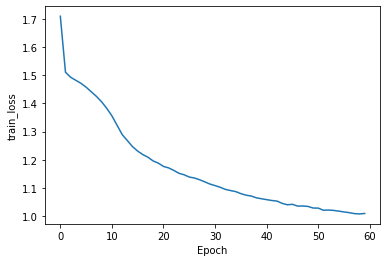

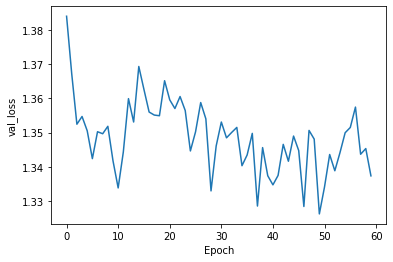

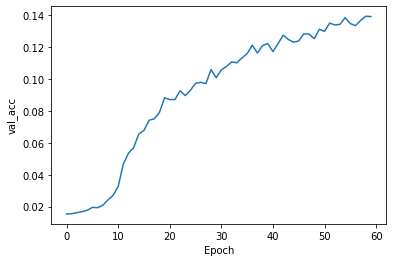


train_loss: [1.7086362361907959, 1.510286601384481, 1.4923152446746826, 1.4817108233769736, 1.470990002155304, 1.4572511553764342, 1.4409224311510722, 1.4245700756708781, 1.4055226524670918, 1.3822793285051982, 1.3555367469787598, 1.3223169207572938, 1.2891537427902222, 1.2679545839627584, 1.2464659889539083, 1.2307389815648397, 1.218346365292867, 1.2088828365008035, 1.19571963151296, 1.1881242116292319, 1.1763530294100444, 1.1711837728818257, 1.162276283899943, 1.1520448128382366, 1.1467513561248779, 1.1388645450274149, 1.1353060404459636, 1.1292354742685953, 1.1218071063359578, 1.1139662861824036, 1.1084370255470275, 1.1025711615880331, 1.094993813832601, 1.090955944856008, 1.0871817866961162, 1.080004056294759, 1.0745841304461161, 1.0715114633242289, 1.0652754426002502, 1.0618774175643921, 1.0587384780248006, 1.0556846102078756, 1.0536009152730306, 1.0455886860688528, 1.0405179778734843, 1.042204248905182, 1.0358703792095185, 1.0361029346783956, 1.0347770174344382, 1.02905776699384

In [46]:
plt.plot(train_loss_plot)
plt.xlabel("Epoch")
plt.ylabel("train_loss")
plt.show()

plt.plot(val_loss_plot)
plt.xlabel("Epoch")
plt.ylabel("val_loss")
plt.show()

plt.plot(val_acc_plot)
plt.xlabel("Epoch")
plt.ylabel("val_acc")
plt.show()

print("\ntrain_loss:", train_loss_plot)
print("\nval_loss:", val_loss_plot)
print("\nval_acc:", val_acc_plot)